It seems was have both patients (Diagnosis = 1) and controls (Diagnosis = 0) in this dataset. Let's quickly look how many we have of each

In [24]:
# Load libraries

import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pySuStaIn
import statsmodels.formula.api as smf
from scipy import stats
import sklearn.model_selection
from scipy.interpolate import interp1d
import os
import shutil

In [25]:
# Load and view simulated tutorial data
# The data needs to be in the same directory as your notebook

data = pandas.read_csv('FinalEBM_input.csv')
data

,Unnamed: 0,RID,Diagnosis,W_average_hippo,W_ADAS11,W_average_tau,W_Average_frontal,W_Average_temporal,W_Average_parietal,W_Average_occipital,W_Average_superiorfrontal,W_Average_anteriorcingulate,W_Average_posteriorcingulate,W_Average_precuneus,W_Average_inferiorparietal,W_Average_inferiortemporal
0,0,21,0,-0.442675,-0.725910,-0.046907,0.198814,0.827801,0.370596,0.916692,0.270293,0.090236,0.469295,0.539510,-0.470478,1.517905
1,1,31,0,1.208408,-2.442518,-0.109110,0.196486,0.598093,0.190721,0.063724,0.527321,0.007342,0.381349,-0.402813,-0.091963,0.989604
2,3,56,1,0.401691,-1.784994,-0.009005,0.580999,0.684701,0.579621,1.171055,0.389989,1.311059,0.177668,-0.227982,0.819487,1.651760
3,5,59,1,0.187756,-0.571995,0.000454,0.491392,0.602563,0.774127,0.061574,0.943000,0.353885,0.628442,0.222930,1.562665,1.719080
4,6,69,1,-0.153926,-0.215380,0.062139,-0.480805,-0.428033,0.043973,-0.096262,-0.562571,-0.090341,0.362464,-0.352621,0.122907,-0.188402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,808,6704,0,0.442492,0.636912,-0.087506,1.504040,1.119667,0.594320,1.510380,1.734599,0.617195,0.474693,0.937756,0.995192,1.896241
648,809,6705,2,1.443939,3.167292,-0.150065,0.192404,-0.070038,-0.292768,-0.421116,-0.231828,0.498848,0.832678,-0.375546,-0.213206,-0.489609
649,810,6713,2,0.114254,3.177238,0.062978,-0.195858,-0.467507,-1.002440,-0.529634,-0.367316,0.095096,-1.086925,-0.877930,-0.943650,-0.618818
650,811,6721,2,2.023511,3.184310,0.005101,-0.064755,-0.395750,-0.314841,-0.129030,-0.111031,0.706349,-0.474998,0.108034,-1.076073,-0.648083


In [5]:
data.Diagnosis.value_counts()

Diagnosis
0    391
1    196
2     65
Name: count, dtype: int64

In [27]:
# store our biomarker labels as a variable
biomarkers = data.columns[3:9]
print(biomarkers)

Index(['W_average_hippo', 'W_ADAS11', 'W_average_tau', 'W_Average_frontal',
       'W_Average_temporal', 'W_Average_parietal'],
      dtype='object')


## Plotting input features

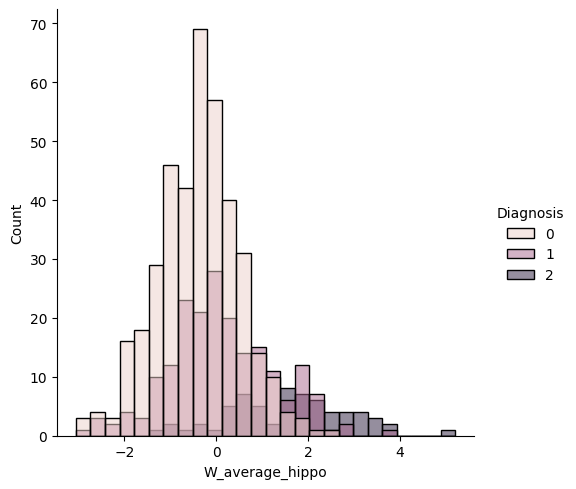

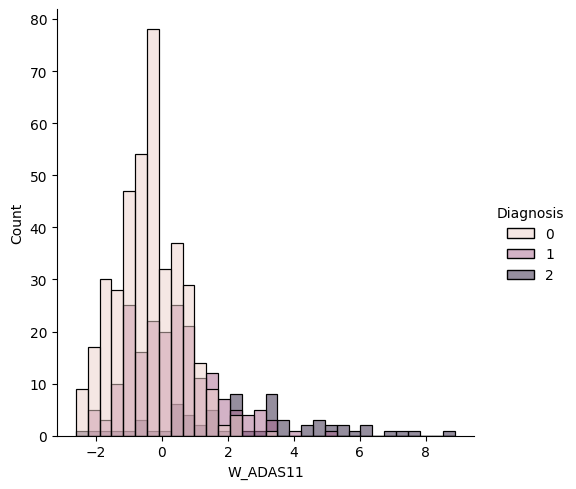

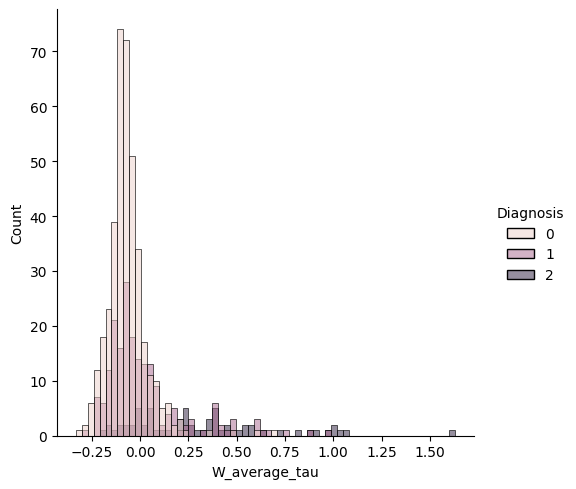

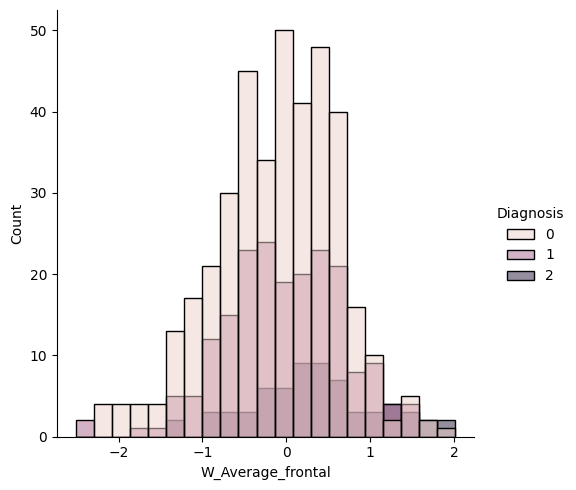

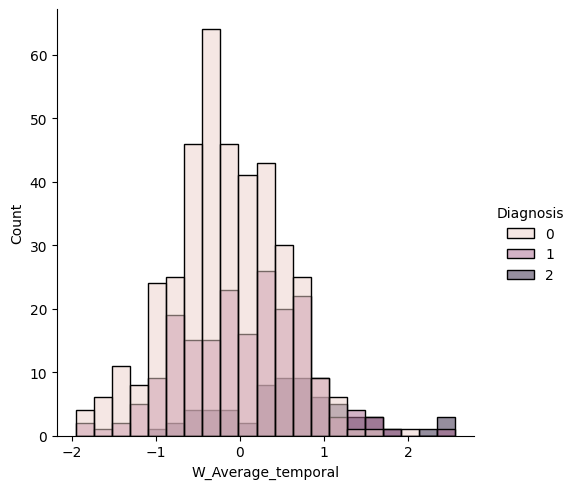

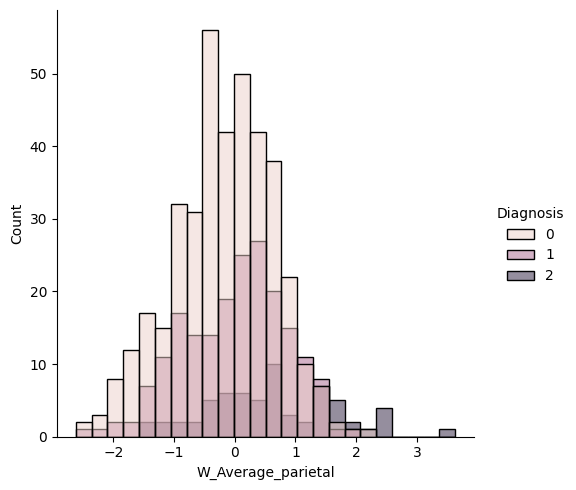

In [28]:
# Plot biomarker histograms check their distributions

for biomarker in biomarkers: 
    sns.displot(x=data[biomarker],hue='Diagnosis',data=data)

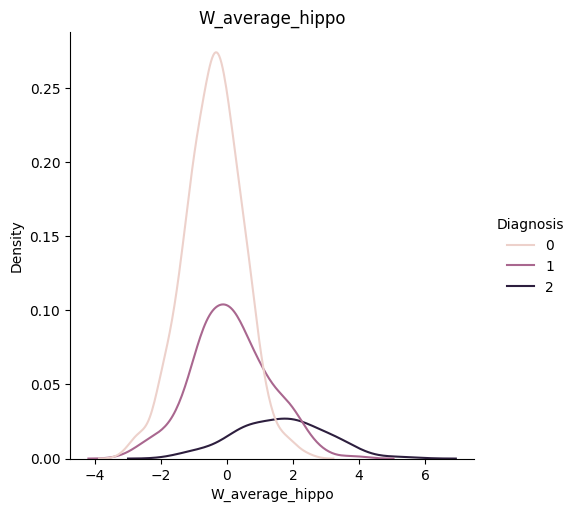

In [29]:
# first a quick look at the patient and control distribution for one of our biomarkers

# make a copy of our dataframe (we don't want to overwrite our original data)
zdata = pandas.DataFrame(data,copy=True)

biomarker = biomarkers[0]
sns.displot(data=data, # our dataframe
            x=biomarker, # name of the the distribution we want to plot
            hue='Diagnosis', # the "grouping" variable
            kind='kde') # kind can also be 'hist' or 'ecdf'
plt.title(biomarker)
plt.show()

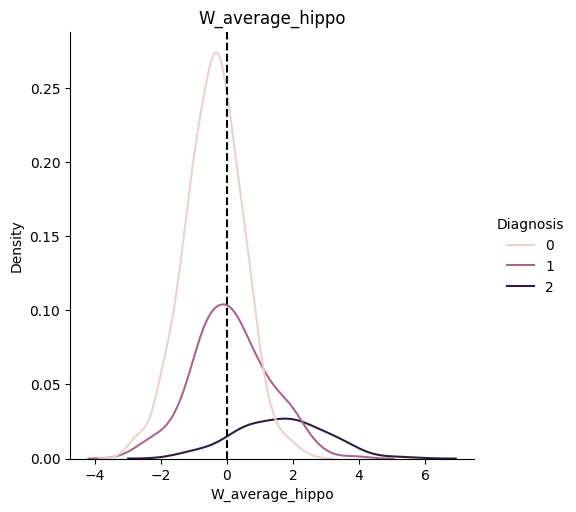

In [30]:
biomarker = biomarkers[0]
sns.displot(data=zdata,x=biomarker,hue='Diagnosis',kind='kde')
plt.title(biomarker)
plt.axvline(0,ls='--',c='black') # the 0 line *should* be the mean of the control distribution
plt.show()

# Prepare SuStaIn inputs

In [31]:
N = len(biomarkers)         # number of biomarkers

SuStaInLabels = biomarkers

Z_vals = np.array([[0.1,1.6,2.2],[0.1,2.2,4.2],[0.1,0.3,0.6],[0.9,1.4,1.8],[0.4,1.3,1.7],[0.9,1.5,1.8]])     # Z-scores for each biomarker --> adjust this! 

# Lobe z-vals: [0.9,1.4,1.8],[0.4,1.3,1.7],[0.9,1.5,1.8],[1,1.5,2] (order: frontal, temporal, parietal, occipital)
# Core biomarker z-vals: [0.1,1.6,2.2],[0.1,2.2,4.2],[0.1,0.3,0.6] (order: hippo, cog score, tau)
# Subregion z-vals: [1.1,1.5,2],[0,9,1.3,2],[1.2,1.5,2],[1,1.5,2.5],[1.2,1.6,2],[1.5,2,2.5] (order: superior frontal, anterior cingulate, posterior cingulate, precuneus, inferior parietal, inferior temporal)


Z_max  = np.array([6,11,2,4,4,5])  # maximum z-score

# Lobe z_max: 4,4,5,3
# Core biomarker z_max: 6,11,2
# Subregion z-max: 4,4,4,5,4,5


In [13]:
print(Z_vals)
print(Z_max)

[[0.1 1.6 2.2]
 [0.1 2.2 4.2]
 [0.1 0.3 0.6]]
[ 6 11  2]


In [32]:
# Input the settings for z-score SuStaIn
# To make the tutorial run faster I've set 
# N_startpoints = 10 and N_iterations_MCMC = int(1e4)
# I recommend using N_startpoints = 25 and 
# N_iterations_MCMC = int(1e5) or int(1e6) in general though

N_startpoints = 25
N_S_max = 1
N_iterations_MCMC = int(1e3) # Increase this to 1e5 or 1e6
output_folder = os.path.join(os.getcwd(), 'WorkshopOutput')
dataset_name = 'WorkshopOutput'

# Initiate the SuStaIn object
sustain_input = pySuStaIn.ZscoreSustain(
                              zdata[biomarkers].values,
                              Z_vals,
                              Z_max,
                              SuStaInLabels,
                              N_startpoints,
                              N_S_max, 
                              N_iterations_MCMC, 
                              output_folder, 
                              dataset_name, 
                              False)

# Run SuStaIn!

In [33]:
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)

In [34]:
# make the output directory if it's not already created
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

In [35]:
   samples_sequence,   \
samples_f,          \
ml_subtype,         \
prob_ml_subtype,    \
ml_stage,           \
prob_ml_stage,      \
prob_subtype_stage  = sustain_input.run_sustain_algorithm()

Failed to find pickle file: /home/robin/sustaln/pySuStaIn/notebooks/WorkshopOutput/pickle_files/WorkshopOutput_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -5835.209872713855


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1000 [00:00<?, ?it/s]

In [36]:
# Get model output from pickle file
s = 0
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pandas.read_pickle(pickle_filename_s)

# Assess likelihood across MCMC samples
Use to assess the selections of z_vals for each biomarker. Use whichever combination of z_vals maximizes likelihood.

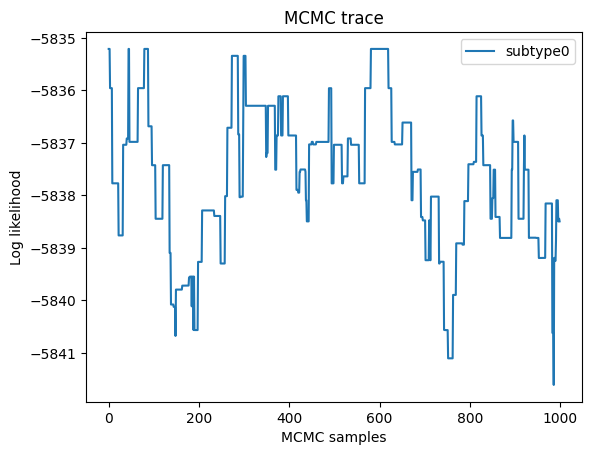

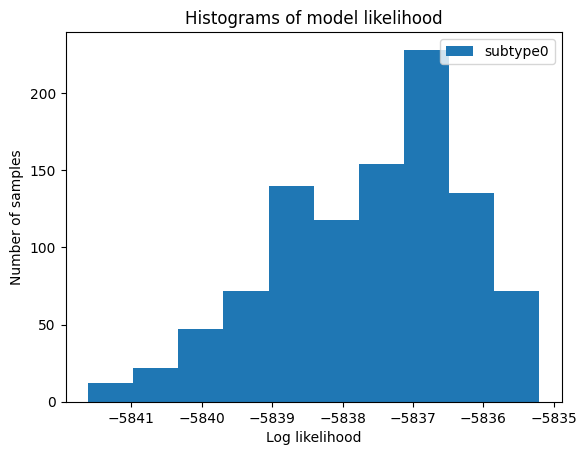

In [37]:
for s in range(N_S_max):
    # load pickle file (SuStaIn output) and get the sample log likelihood values
    pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
    pk = pandas.read_pickle(pickle_filename_s)
    samples_likelihood = pk["samples_likelihood"]
    
    # plot the values as a line plot
    plt.figure(0)
    plt.plot(range(N_iterations_MCMC), samples_likelihood, label="subtype" + str(s))
    plt.legend(loc='upper right')
    plt.xlabel('MCMC samples')
    plt.ylabel('Log likelihood')
    plt.title('MCMC trace')
    
    # plot the values as a histogramp plot
    plt.figure(1)
    plt.hist(samples_likelihood, label="subtype" + str(s))
    plt.legend(loc='upper right')
    plt.xlabel('Log likelihood')  
    plt.ylabel('Number of samples')  
    plt.title('Histograms of model likelihood')

# Stage individuals

In [38]:
# let's take a look at all of the things that exist in SuStaIn's output (pickle) file
pk.keys()

dict_keys(['samples_sequence', 'samples_f', 'samples_likelihood', 'ml_subtype', 'prob_ml_subtype', 'ml_stage', 'prob_ml_stage', 'prob_subtype', 'prob_stage', 'prob_subtype_stage', 'ml_sequence_EM', 'ml_sequence_prev_EM', 'ml_f_EM', 'ml_f_prev_EM'])

In [39]:
# The SuStaIn output has everything we need. We'll use it to populate our dataframe.

s = 0
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pandas.read_pickle(pickle_filename_s)

for variable in ['ml_subtype', # the assigned subtype
                 'prob_ml_subtype', # the probability of the assigned subtype
                 'ml_stage', # the assigned stage 
                 'prob_ml_stage',]: # the probability of the assigned stage
    
    # add SuStaIn output to dataframe
    zdata.loc[:,variable] = pk[variable] 

# We don't need this 
# let's also add the probability for each subject of being each subtype
#for i in range(s):
    #zdata.loc[:,'prob_S%s'%i] = pk['prob_subtype'][:,i]

zdata

,Unnamed: 0,RID,Diagnosis,W_average_hippo,W_ADAS11,W_average_tau,W_Average_frontal,W_Average_temporal,W_Average_parietal,W_Average_occipital,W_Average_superiorfrontal,W_Average_anteriorcingulate,W_Average_posteriorcingulate,W_Average_precuneus,W_Average_inferiorparietal,W_Average_inferiortemporal,ml_subtype,prob_ml_subtype,ml_stage,prob_ml_stage
0,0,21,0,-0.442675,-0.725910,-0.046907,0.198814,0.827801,0.370596,0.916692,0.270293,0.090236,0.469295,0.539510,-0.470478,1.517905,0.0,1.0,2.0,0.191787
1,1,31,0,1.208408,-2.442518,-0.109110,0.196486,0.598093,0.190721,0.063724,0.527321,0.007342,0.381349,-0.402813,-0.091963,0.989604,0.0,1.0,5.0,0.196313
2,3,56,1,0.401691,-1.784994,-0.009005,0.580999,0.684701,0.579621,1.171055,0.389989,1.311059,0.177668,-0.227982,0.819487,1.651760,0.0,1.0,4.0,0.175388
3,5,59,1,0.187756,-0.571995,0.000454,0.491392,0.602563,0.774127,0.061574,0.943000,0.353885,0.628442,0.222930,1.562665,1.719080,0.0,1.0,3.0,0.174049
4,6,69,1,-0.153926,-0.215380,0.062139,-0.480805,-0.428033,0.043973,-0.096262,-0.562571,-0.090341,0.362464,-0.352621,0.122907,-0.188402,0.0,1.0,0.0,0.250158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,808,6704,0,0.442492,0.636912,-0.087506,1.504040,1.119667,0.594320,1.510380,1.734599,0.617195,0.474693,0.937756,0.995192,1.896241,0.0,1.0,4.0,0.170561
648,809,6705,2,1.443939,3.167292,-0.150065,0.192404,-0.070038,-0.292768,-0.421116,-0.231828,0.498848,0.832678,-0.375546,-0.213206,-0.489609,0.0,1.0,8.0,0.521861
649,810,6713,2,0.114254,3.177238,0.062978,-0.195858,-0.467507,-1.002440,-0.529634,-0.367316,0.095096,-1.086925,-0.877930,-0.943650,-0.618818,0.0,1.0,8.0,0.322513
650,811,6721,2,2.023511,3.184310,0.005101,-0.064755,-0.395750,-0.314841,-0.129030,-0.111031,0.706349,-0.474998,0.108034,-1.076073,-0.648083,0.0,1.0,8.0,0.539300


In [40]:
# Save zdata to a new file for analysis (GO TO PROCESSING MODEL OUTPUT TO CONTINUE IGNORE ALL FOLLOWING CODE)
zdata.to_csv('zdata.csv')

In [41]:
#zdata.ml_subtype.value_counts()
zdata.ml_stage.value_counts()

ml_stage
0.0     468
1.0      55
5.0      51
2.0      48
4.0      47
3.0      45
6.0      22
7.0      16
8.0      14
10.0      7
9.0       7
15.0      7
17.0      7
13.0      5
12.0      4
11.0      3
14.0      2
20.0      2
16.0      1
21.0      1
18.0      1
Name: count, dtype: int64

As a sanity check, let's make sure all the "controls" were given assigned to low stages by SuStaIn

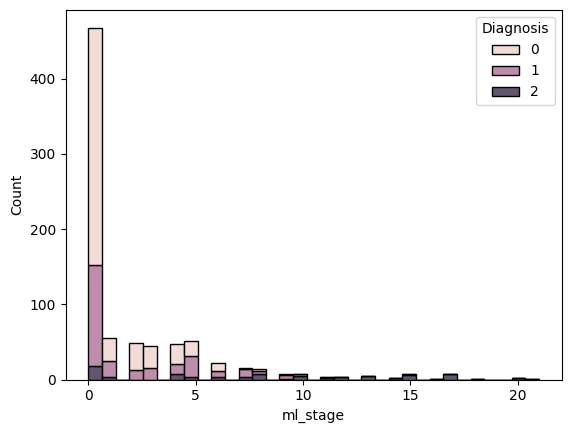

In [42]:
# Use clincial diagnostic categories as a rough way to assess the sucess of the model's stage assignments

#sns.displot(x='ml_stage',hue='Diagnosis',data=zdata)

sns.histplot(data=zdata, x='ml_stage', hue='Diagnosis', multiple='stack')
plt.show()

# Trajectory plots for each biomarker

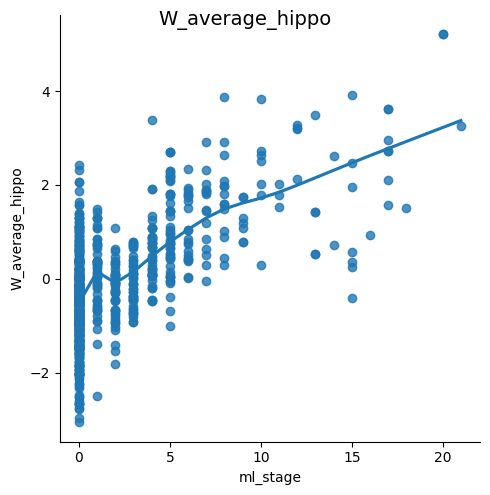

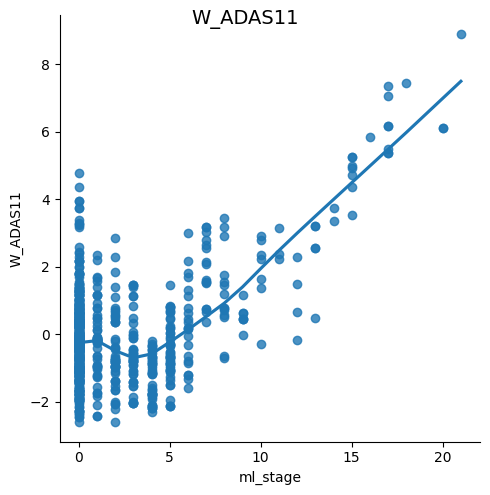

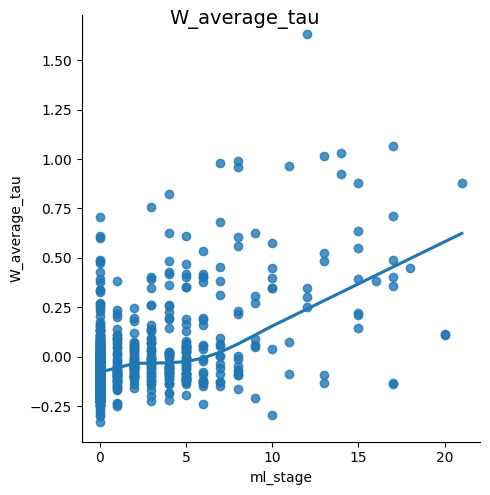

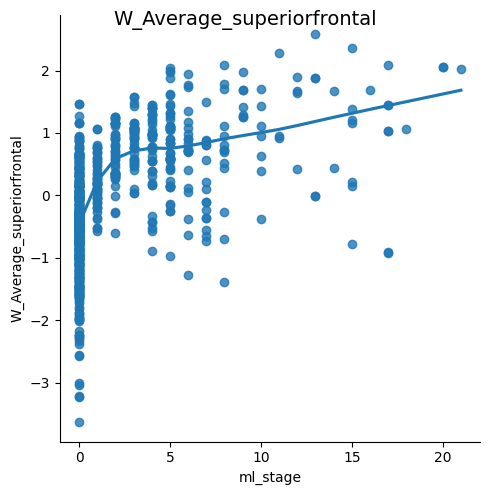

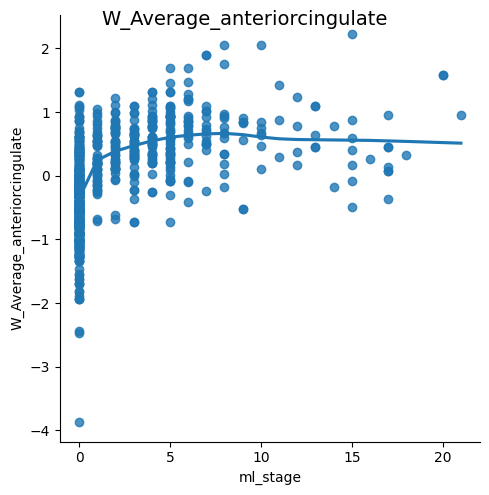

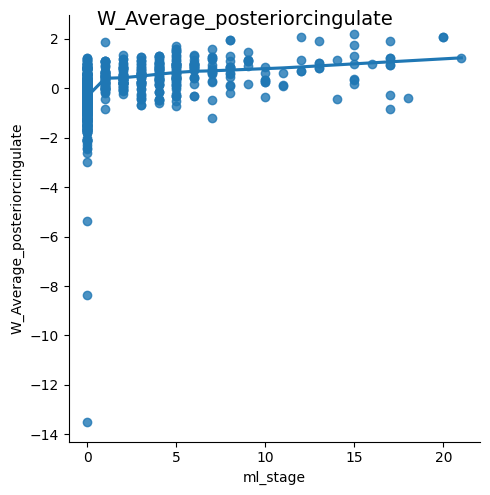

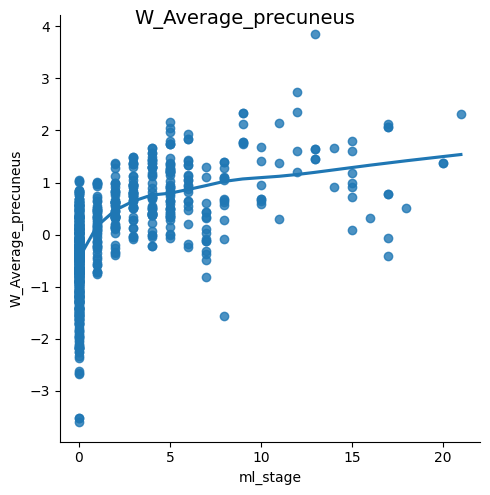

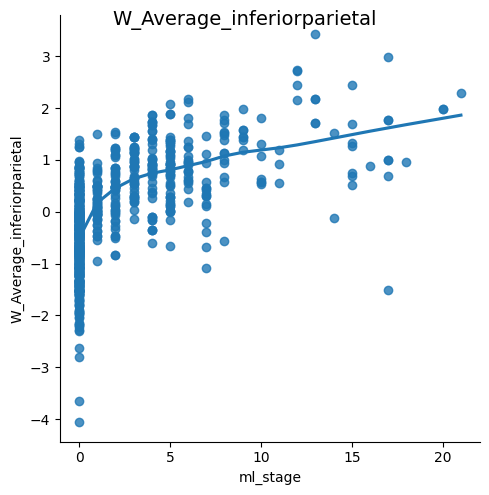

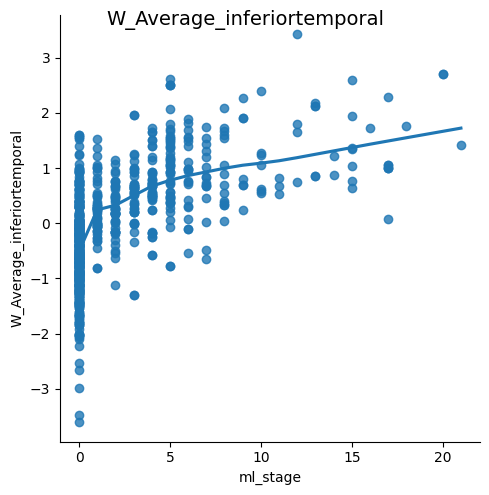

In [46]:
# Compare these plots to known biomarker trajectories for AD to validate model output

for biomarker in biomarkers:
    
    var = biomarker

    # plot relationship between each biomarker and stage for each subject
    sns.lmplot(x='ml_stage',y=var,
          data = zdata,
           lowess=True # uncomment if you would prefer a lowess curve to a linear curve
          ) 

    # Add a title to the plot
    plt.gcf().suptitle(biomarker, fontsize=14) 

    plt.show()

## Raw data trajectory plots for each biomarker 
Another way to check staging is accurate (requested by Sri)

In [37]:
# Get raw tau data to plot 

data = pandas.read_csv('Cog_Tau_V1.csv')

# Find the average of the right and left cerebellum 
data['Average_Cerebellum'] = (data['Left-Cerebellum-Cortex']+ data['Right-Cerebellum-Cortex'])/2

# Change every '-' to '_' in column title names (to avoid errors later on)
data.columns = [c.replace('-', '_') for c in data.columns]

# Divide each regional tau value by the average of R and L cerebellum tau and subtract 1
data[['ctx_rh_inferiortemporal', 'ctx_rh_middletemporal', 'ctx_rh_parahippocampal', 'ctx_lh_entorhinal', 'ctx_lh_fusiform', 'ctx_lh_inferiortemporal', 'ctx_lh_middletemporal', 'ctx_lh_parahippocampal', 'Left_Amygdala', 'Right_Amygdala']] = data[['ctx_rh_inferiortemporal', 'ctx_rh_middletemporal', 'ctx_rh_parahippocampal', 'ctx_lh_entorhinal', 'ctx_lh_fusiform', 'ctx_lh_inferiortemporal', 'ctx_lh_middletemporal', 'ctx_lh_parahippocampal', 'Left_Amygdala', 'Right_Amygdala']].div(data['Average_Cerebellum'], axis=0)
data[['ctx_rh_inferiortemporal', 'ctx_rh_middletemporal', 'ctx_rh_parahippocampal', 'ctx_lh_entorhinal', 'ctx_lh_fusiform', 'ctx_lh_inferiortemporal', 'ctx_lh_middletemporal', 'ctx_lh_parahippocampal', 'Left_Amygdala', 'Right_Amygdala']] = data[['ctx_rh_inferiortemporal', 'ctx_rh_middletemporal', 'ctx_rh_parahippocampal', 'ctx_lh_entorhinal', 'ctx_lh_fusiform', 'ctx_lh_inferiortemporal', 'ctx_lh_middletemporal', 'ctx_lh_parahippocampal', 'Left_Amygdala', 'Right_Amygdala']] - 1

# Take average of all meta tau regions
data['Average_Tau'] = data[['ctx_rh_inferiortemporal', 'ctx_rh_middletemporal', 'ctx_rh_parahippocampal', 'ctx_lh_entorhinal', 'ctx_lh_fusiform', 'ctx_lh_inferiortemporal', 'ctx_lh_middletemporal', 'ctx_lh_parahippocampal', 'Left_Amygdala', 'Right_Amygdala']].mean(axis=1)

# Add in columns with demographic data so we can perform age regression 
with_demo = pandas.read_csv('Regional_Tau_w_Demographics.csv')
with_demo = with_demo[['AGE', 'RID']]

# Rename column titles for consistency 
data = data.rename(columns={'merge_RID': 'RID'})
with_demo = with_demo.rename(columns={'AGE':'Age'})

data = pandas.merge(data, with_demo, left_index=True, right_index=True)
data = data[['RID_x', 'merge_DX', 'Age','Average_Tau']]
data = data.rename(columns={'RID_x': 'RID'})
data = data.rename(columns={'merge_DX': 'Diagnosis'})

value_to_drop = [4513, 6038, 6505, 6598]  
    
# Drop rows where 'RID' matches any value in 'value_to_drop'
data = data[~data['RID'].isin(value_to_drop)]

data

,RID,Diagnosis,Age,Average_Tau
0,21,CN,72.6,0.179657
1,31,CN,77.7,0.119621
2,31,CN,77.7,0.128919
3,56,MCI,69.6,0.216284
4,56,MCI,69.6,0.234038
...,...,...,...,...
814,6704,CN,65.3,0.135957
815,6705,Dementia,74.9,0.077476
816,6713,Dementia,71.1,0.288904
817,6721,Dementia,77.9,0.233916


In [38]:
# Add raw tau data to zdata 
zdata['Raw_tau'] = data['Average_Tau']

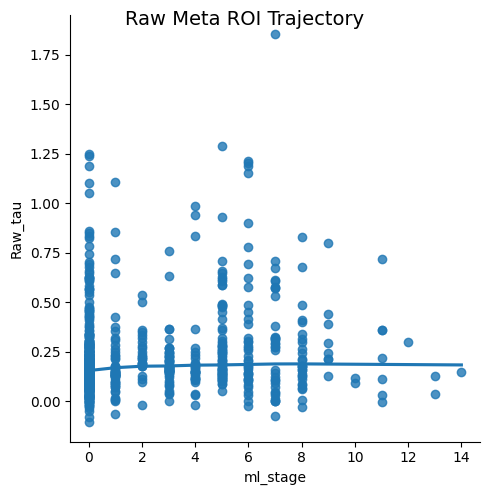

In [39]:
var = 'Raw_tau' #W_MMSE if using MMSE instead of ADAS

# plot relationship between MMSE and stage for each subject
sns.lmplot(x='ml_stage',y=var,
          data = zdata,
           lowess=True # uncomment if you would prefer a lowess curve to a linear curve
          )  

# Add a title to the plot
plt.gcf().suptitle('Raw Meta ROI Trajectory', fontsize=14) 

plt.show()

In [261]:
# Get raw ADAS11 data 

data = pandas.read_csv('Regional_Tau_w_Demographics.csv')

# Rename columns for consistency
data = data.rename(columns={'merge_DX': 'Diagnosis'})
data = data.rename(columns={'AGE': 'Age'})

# Delete unneeded columns 
data = data[['RID', 'Age', 'Diagnosis', 'ADAS11_bl']]

value_to_drop = [4513, 6038, 6505, 6598]  
    
# Drop rows where 'RID' matches any value in 'value_to_drop'
data = data[~data['RID'].isin(value_to_drop)]

data

,RID,Age,Diagnosis,ADAS11_bl
0,21,72.6,CN,6.67
1,31,77.7,CN,1.67
2,31,77.7,CN,1.67
3,56,69.6,MCI,3.00
4,56,69.6,MCI,3.00
...,...,...,...,...
814,6704,65.3,CN,10.33
815,6705,74.9,Dementia,19.33
816,6713,71.1,Dementia,19.00
817,6721,77.9,Dementia,19.67


In [262]:
# Add raw ADAS11 data to zdata 
zdata['Raw_ADAS11'] = data['ADAS11_bl']

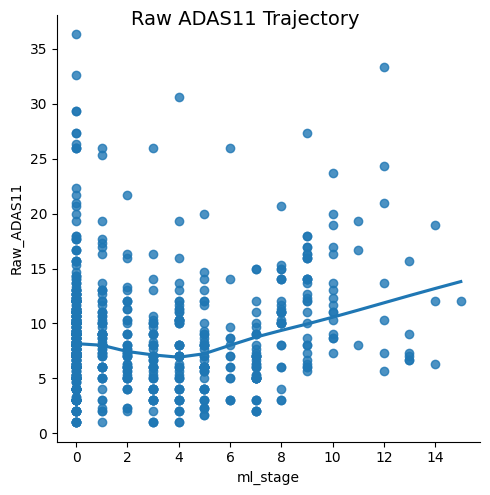

In [263]:
var = 'Raw_ADAS11' #W_MMSE if using MMSE instead of ADAS

# plot relationship between MMSE and stage for each subject
sns.lmplot(x='ml_stage',y=var,
          data = zdata,
           lowess=True # uncomment if you would prefer a lowess curve to a linear curve
          )  

# Add a title to the plot
plt.gcf().suptitle('Raw ADAS11 Trajectory', fontsize=14) 

plt.show()

In [264]:
# Get raw hippocampal volume data (already z-scored)

data = pandas.read_csv('ADNI_neg_zscores_orig.csv')

# Delete unneeded rows 
data = data[['RID', 'Left-Hippocampus', 'Right-Hippocampus']]

# Take average of right and left hippocampal hemisphere columes 
data['Average_hippo'] = data[['Left-Hippocampus', 'Right-Hippocampus']].mean(axis=1)

# Delete unneeded columns
data = data[['RID','Average_hippo']]

value_to_drop = [4513, 6038, 6505, 6598]  
    
# Drop rows where 'RID' matches any value in 'value_to_drop'
data = data[~data['RID'].isin(value_to_drop)]

In [265]:
# Add raw hippo data to zdata 
zdata['Raw_hippo'] = data['Average_hippo']

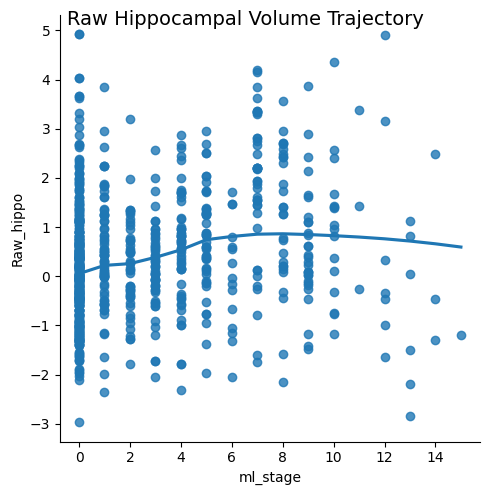

In [266]:
var = 'Raw_hippo' #W_MMSE if using MMSE instead of ADAS

# plot relationship between MMSE and stage for each subject
sns.lmplot(x='ml_stage',y=var,
          data = zdata,
           lowess=True # uncomment if you would prefer a lowess curve to a linear curve
          )  

# Add a title to the plot
plt.gcf().suptitle('Raw Hippocampal Volume Trajectory', fontsize=14) 

plt.show()

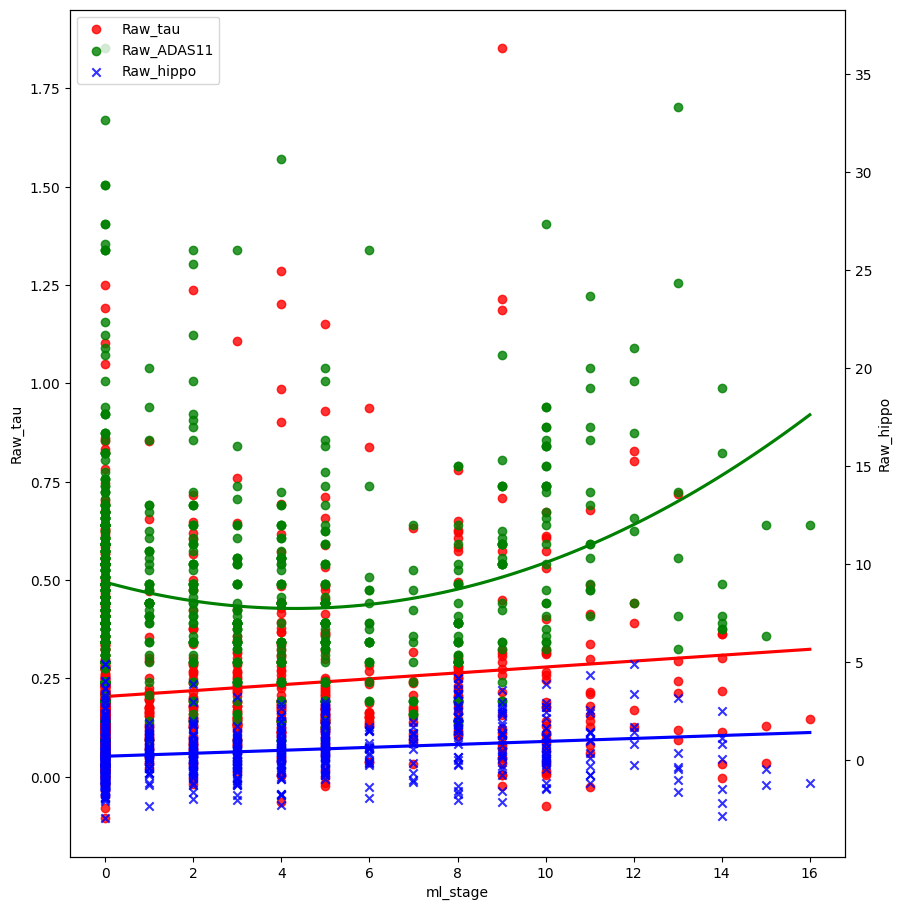

In [170]:
# THIS PLOT PROVED UNUSEFUL (IGNORE!)

# Plot all biomarkers on the same plot to compare trajectories 

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 11))

# First plot
sns.regplot(x='ml_stage', y='Raw_tau', data=zdata, order= 1, ax=ax1, color='r', label='Raw_tau', ci=None)

# Second plot with shared x-axis but new y-axis
ax2 = ax1.twinx()
sns.regplot(x='ml_stage', y='Raw_ADAS11', data=zdata, order= 2, ax=ax2, color='g', label='Raw_ADAS11', ci=None)

# Third plot reusing ax2 for simplicity.
sns.regplot(x='ml_stage', y='Raw_hippo', data=zdata, order= 1, ax=ax2, color='b', marker='x', label='Raw_hippo',ci=None)

# Handling legends since we're using two different axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# Adjust the spacing between ticks (optional, see step 2)
#plt.yticks(np.arange(0, 6, 0.5))  # Example: setting y-ticks from 0 to 6 with a step of 0.5

plt.show()

# Calculate y_k at each stage for a biomarker
Can use this code for any biomarker, including tau regional values and functional metrics

In [40]:
# Load data for biomarker of interest (in this case tau regional data)
tau_data = pandas.read_csv('Cog_Tau_V1.csv')

In [41]:
# Delete RIDs with NaN values in any column 

value_to_drop = [4513, 6038, 6505, 6598]  
    
# Drop rows where 'RID' matches any value in 'value_to_drop'
tau_data = tau_data[~tau_data['merge_RID'].isin(value_to_drop)]

In [42]:
# Create a data frame for the stage probability distributions for each subject from pickle file
prob_stage = pandas.DataFrame(pk['prob_stage'])

# Define the number of stages 
stage_count = prob_stage.shape[1]
    
# Define biomarker of interest as an array dimensions 1 x i where i is the number of subjects
biomarker_of_interest = 'ctx-rh-entorhinal' # INPUT BIOMARKER OF INTEREST HERE exactly as it appears in column title   
biomarker_data = tau_data[biomarker_of_interest]
    

In [43]:
# Initialize list of y(k) values for each stage k
biomarker_values = []

for k in range(int(stage_count)): # For each stage k
    sum = 0 # Define a variable for sum of all subjects i (numerator)
    
    for i in range(len(biomarker_data)): # For each subject i 
        
        prob = prob_stage.iloc[i, k] # Define the probability that subject i is in stage k
        value = biomarker_data.iloc[i] # Define the value of the biomarker for subject i 
        product = prob * value # Multiply 
        sum = sum + product # Add the product of the biomarker value and stage probability to the sum of i for stage k

    column_sum = np.sum(prob_stage.iloc[:, k]) # (denominator)

    final_value = sum / column_sum # Normalize with sum of probabilities for each subject in stage k
    
    biomarker_values.append(final_value) # Save sum to biomarker_values list

# Print list of y(k) values (each value in list corresponds to a stage k)
print(biomarker_values)

[1.1216226688828062, 1.129005102431209, 1.1370403765720107, 1.1440025745219722, 1.1629992756642964, 1.2066103013349183, 1.3095528325221495, 1.4221200792872735, 1.3756842469235984, 1.4339872314982844, 1.4825353535849883, 1.4678211148359803, 1.4746619081248256, 1.5631776239000246, 1.6714424905527752, 1.7111165541320548, 1.719525533017917, 1.7210351681327627, 1.721650154568851]


# Gaussian Interpolation 
Create and plot a continuous time series from discrete y_k values for biomarker of interest

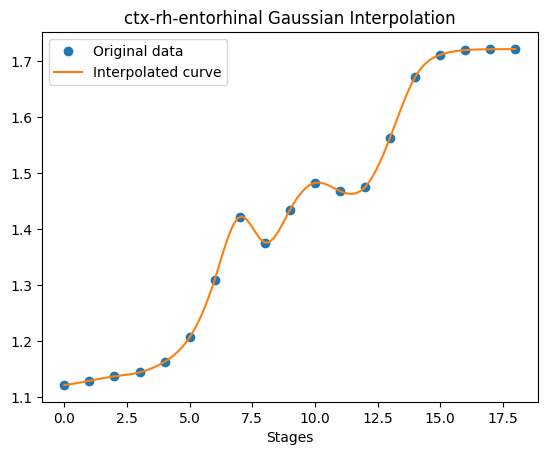

In [44]:
# With scipy.interpolate.interp1d

x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18] # With lobar volumes include: 10,11,12,13,14,15,16,17,18,19,20,21
y = biomarker_values # SPECIFY WHICH APPROACH

# Perform interpolation 
f = interp1d(x, y, kind='cubic')

# New x values for which we want to interpolate
xnew = np.linspace(0,18,100) # With lobar volumes (0,21,100)

# Interpolate y values for the new x values
ynew = f(xnew)

# Plotting
plt.plot(x, y, 'o', label='Original data')
plt.plot(xnew, ynew, '-', label='Interpolated curve')
plt.legend()
plt.xlabel('Stages')
plt.title(biomarker_of_interest + ' Gaussian Interpolation')
plt.show()

# Calculate a continous time series for a biomarker in every brain region
Perform the above operations for every brain region (currently looking at tau)

In [45]:
# Now let's calculate an interpolation for tau in every region (using approach 2) --> this will become T(t) in Aim 2

# Define an array for tau interpolations in every brain region
tau_array = None

for region in tau_data.columns[7:]: # Loop through tau in every region (CUSTOMIZE BASED ON COLUMNS IN YOUR DATA FRAME)
    
    # Define biomarker of interest as an array dimensions 1 x i where i is the number of subjects
    biomarker_of_interest = region  
    biomarker_data = tau_data[biomarker_of_interest]

    # Initialize list of y(k) values for each stage k
    biomarker_values = []
    

    for k in range(int(stage_count)): # For each stage k
        sum = 0 # Define a variable for sum of all subjects i (numerator)
    
        for i in range(len(zdata)): # For each subject i 
        
            prob = prob_stage.iloc[i, k] # Define the probability that subject i is in stage k
            value = biomarker_data.iloc[i] # Define the value of the biomarker for subject i 
            product = prob * value # Multiply 
            sum = sum + product # Add the product of the biomarker value and stage probability to the sum of i for stage k

        column_sum = np.sum(prob_stage.iloc[:, k]) # (denominator)

        final_value = sum / column_sum # Normalize with sum of probabilities for each subject in stage k
    
        biomarker_values.append(final_value) # Save sum to biomarker_values list

    
    # Perform Gaussian interpolation with scipy.interpolate.interp1d

    x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
    y = biomarker_values

    # Perform interpolation 
    f = interp1d(x, y, kind='cubic')

    # New x values for which we want to interpolate
    xnew = np.linspace(0,18,100)

    # Interpolate y values for the new x values
    ynew = f(xnew)

    if tau_array is None:
        tau_array = ynew[np.newaxis, :]  # Make ynew 2D for vertical stacking
    else:
        tau_array = np.vstack((tau_array, ynew))
        
print(tau_array)

[[1.17458803 1.17556912 1.17671804 ... 2.39472032 2.40279617 2.41393905]
 [1.02168196 1.02206614 1.02250763 ... 1.3193365  1.32057818 1.32229277]
 [1.01583734 1.01668784 1.01766914 ... 2.4062113  2.41456189 2.42613134]
 ...
 [1.20006291 1.20115568 1.20246375 ... 1.66023643 1.6605682  1.66103207]
 [1.22330657 1.22391936 1.22462263 ... 1.2522141  1.25135242 1.25012594]
 [1.23110448 1.23140589 1.23173923 ... 1.12941609 1.12888155 1.12813493]]


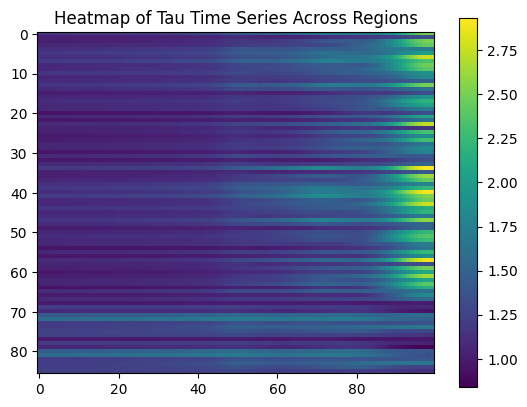

In [63]:
# Generate a heat map of ynew

# Generate heatmap
plt.imshow(tau_array, cmap='viridis', interpolation='none')
plt.colorbar()  # Add a color bar to map colors to values
plt.title('Heatmap of Tau Time Series Across Regions')
plt.show()